<h1><center><b>COURSE: CSCE 155T</b></center></h1>
<h3><center><b>Introduction to Computer Science I: Informatics</b></center></h3>
<h5><b>Course Description:</b></h5>

This 16-week introductory course offers a foundation in computer science and data science, equipping students with essential programming, algorithmic thinking, and problem-solving skills. Using Python as the primary programming language, the course covers fundamental programming constructs, data structures, file handling, and an introduction to data visualization techniques. By applying these skills to real-world datasets and problems, students gain practical experience and develop interdisciplinary connections. Designed for students without prior programming experience, the course aims to create a supportive learning environment that inspires students to further hone their computational abilities and critical thinking skills.

---

<h4><b>Module Topic:</b><u>Designing Methods to Estimate US Poverty Data Using Spatial Interpolation and Ethical Considerations</u><h4>

---

<b>Note:</b> This module focuses on the technical aspects and hands-on exercises related to spatial interpolation and data-driven decision-making. It builds upon the foundation established in previous lectures, where guest a speaker from the Department of Philosophy provided an introduction to ethical considerations in computer science applications.

<b>Acknowledgment:</b> This module was co-developed by <a href="https://cse.unl.edu/~charper/">Colton Harper</a> and Zachariah Wrublewski.


<h4><b><u>Module Overview:</u></b></h4>

In this module, students work with an interactive Python notebook that guides them through the process of designing, coding, and evaluating a method to estimate US poverty data using spatial interpolation techniques. The primary focus is on exploring the ethical considerations involved in designing and implementing data-driven solutions, as well as understanding the implications of these decisions on various stakeholders.

---
<h4><b><u>Learning Objectives:</u></b></h4>
Through hands-on coding exercises, collaborative problem-solving, and reflective discussions, students will:

1. Enhance students' understanding of the ethical considerations in using spatial interpolation methods for estimating poverty data in real-world scenarios.
2. Encourage students to think critically about the potential consequences of their methodological choices for various stakeholders, including direct and indirect ones.
3. Reinforce students' ability to apply spatial interpolation techniques while considering the ethical dimensions of their work.


<h4><b><u>Key Questions:</u></b></h4>

- What ethical considerations should be taken into account when using spatial interpolation methods to estimate poverty data?
- How do the choices made in designing a method impact various stakeholders, both directly and indirectly?
- How can students balance the need for accurate estimations with the ethical implications of their work?

<h4><b><u>Key Concepts:</u></b></h4>

- Ethical dimensions in spatial interpolation and data-driven decision-making
Identifying and addressing the needs of direct and indirect stakeholders
- Evaluating trade-offs and potential consequences of methodological choices in a design/development context
- Balancing accuracy, fairness, and transparency in data-driven solutions
- Developing a responsible and informed approach to the design and implementation of algorithms and data analysis methods
- Navigating ethical dilemmas and complexities in computer science applications

[Jump To Scenario](#scenario)

# <b>Interpolation of Census Data</b>

Interpolation content and illustrations adapted from: https://gisgeography.com/inverse-distance-weighting-idw-interpolation/

## <b>Utility Functions</b>

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import math
import requests
from urllib.request import urlopen
import json
import os
import matplotlib.pyplot as plt


censusVar = 'DP03_0120PE'

class DataDownloader:
    """
    The DataDownloader class is responsible for downloading FIPS codes and county center coordinates data.
    """
    def __init__(self):
        self.fipsDf = None
        self.countyCenters = None
        
    def download_fips_data(self):
        """
        Downloads FIPS codes data from a remote source and stores it as a pandas DataFrame.
        """
        url = "https://raw.githubusercontent.com/ChuckConnell/articles/master/fips2county.tsv"
        self.fipsDf = pd.read_csv(url, sep='\t', header='infer', dtype=str, encoding='latin-1')
        
    def download_county_centers(self):
        """
        Downloads county center coordinates from a remote source and stores it as a pandas DataFrame.
        """
        url = "https://www.cse.unl.edu/~charper/155t/embeddedEthics/countyGeoCenter_latLong.txt"
        self.countyCenters = pd.read_csv(url, sep='\t', dtype=str)
        self.countyCenters = self.countyCenters[['FIPS', 'Latitude', 'Longitude']]
        self.countyCenters = self.countyCenters.rename(columns={'FIPS': 'fips_id'})

class CountyData:
    """
    The CountyData class is responsible for handling county data operations.
    """
    def __init__(self, data_downloader):
        """
        Initializes a CountyData object with a DataDownloader object.
        
        Args:
            data_downloader (DataDownloader): A DataDownloader object to access FIPS codes and county center coordinates.
        """
        self.data_downloader = data_downloader
        
    def countyNameStateNameToFips(self, countyName, stateName):
        """
        Returns the FIPS code for a given county and state name.
        
        Args:
            countyName (str): The name of the county.
            stateName (str): The name of the state.
        
        Returns:
            str: The FIPS code of the county if found, otherwise "-1".
        """
        state_fips = self.data_downloader.fipsDf[self.data_downloader.fipsDf["StateName"] == stateName]
        county_fips = state_fips[state_fips["CountyName"] == countyName]
        fip_id = county_fips["CountyFIPS"]
        if fip_id.size > 0:
            return county_fips["CountyFIPS"].values[0]
        else:
            print("County Not Found")
            return "-1"

    def addCenterLatLonToCensusData(self, censusData):
        """
        Adds center latitude and longitude data to the given census data.
        
        Args:
            censusData (pd.DataFrame): A pandas DataFrame containing census data.
        
        Returns:
            pd.DataFrame: The updated census data with center latitude and longitude columns.
        """
        neFipIds = [f"31{str((i * 2 - 1)).zfill(3)}" for i in range(1, 94)]
        countyCenters = self.data_downloader.countyCenters[self.data_downloader.countyCenters['fips_id'].isin(neFipIds)]
        censusData = pd.merge(censusData, countyCenters, on='fips_id', how='outer')
        return censusData

class CountyPlotter:
    """
    The CountyPlotter class is responsible for plotting county data on a map.
    """
    def __init__(self):
        self.counties = None
        
    def download_geojson(self):
        """
        Downloads GeoJSON data for US counties and stores it as a dictionary.
        """
        url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
        with urlopen(url) as response:
            self.counties = json.load(response)
            
    def plotCountyData_ne(self, nebraskaCountyData):
        """
        Plots Nebraska county data on a map using Plotly.
        
        Args:
            nebraskaCountyData (pd.DataFrame): A pandas DataFrame containing Nebraska county data.
        """
        fig = px.choropleth(nebraskaCountyData, geojson=self.counties, locations='fips_id', color=censusVar,
                            color_continuous_scale="Viridis",
                            range_color=(0, 30),
                            scope="usa",
                            labels={censusVar: 'Percent in Poverty'})
        fig.update_layout(title_text="Title", margin={"r": 0, "t": 0, "l": 0, "b": 0}, dragmode=False,
                          geo=dict(
                              projection_scale=6.5,
                              center=dict(lat=41.4, lon=-99.9)
                          ))
        fig.show()

class CensusData:
    """
    The CensusData class is responsible for handling census data operations.
    """
    def __init__(self, county_data):
        """
        Initializes a CensusData object with a CountyData object.
        
        Args:
            county_data (CountyData): A CountyData object to access county information.
        """
        self.county_data = county_data
        
    def getCensusPovertyDataByYear_ne(self, year):
        """
        Retrieves census poverty data for Nebraska counties for a specific year.
        
        Args:
            year (int): The year for which census poverty data is required.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the retrieved census poverty data.
        """
        file_path = os.path.join("data", f"census_data_{censusVar}_{year}.csv")
        
        with open(file_path, 'r') as csvfile:
            data = [row for row in csv.reader(csvfile)]

        censusData = pd.DataFrame(data[1:], columns=data[0])

        fips_ids = [row["state"] + row["county"] for _, row in censusData.iterrows()]
        censusData['fips_id'] = fips_ids
        censusData[censusVar] = censusData[censusVar].astype(str).astype(float)
        censusData = censusData.sort_values(by=[censusVar])
        censusData = self.county_data.addCenterLatLonToCensusData(censusData)
        censusData['Latitude'] = pd.to_numeric(censusData['Latitude'])
        censusData['Longitude'] = pd.to_numeric(censusData['Longitude'])
        censusData[censusVar] = pd.to_numeric(censusData[censusVar])
        censusData[["countyName", "stateName"]] = censusData["NAME"].str.split(', ', expand=True)
        censusData.drop('NAME', inplace=True, axis=1)
        return censusData

class SamplingMethods:
    """
    The SamplingMethods class is responsible for various sampling methods on a given DataFrame.
    """
    def __init__(self):
        pass
        
    def getHalfCounties_random(self, dataFrame):
        """
        Randomly selects half of the counties from a given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing county data.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the randomly selected half of counties.
        """
        numCounties = dataFrame.shape[0]
        randomIndicesToSelect = np.random.choice(np.arange(0, numCounties), int(numCounties / 2), replace=False)
        randomlySelectedCountiesData = dataFrame.iloc[randomIndicesToSelect]
        return randomlySelectedCountiesData

    def getHalf_highestPovCounties(self, dataFrameSource, dataFrameTarget):
        """
        Selects half of the highest poverty counties from the source DataFrame and filters the target DataFrame based on these counties.
        
        Args:
            dataFrameSource (pd.DataFrame): A pandas DataFrame containing source county data.
            dataFrameTarget (pd.DataFrame): A pandas DataFrame containing target county data.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the filtered target county data based on half of the highest poverty counties.
        """
        numCountiesToSelect = int(dataFrameSource.shape[0] / 2)
        dataFrameSource = dataFrameSource.sort_values(by=censusVar)
        highestPovertyCounties_fips_ids = dataFrameSource.iloc[numCountiesToSelect:]['fips_id'].to_list()
        dataFrameTarget = dataFrameTarget[dataFrameTarget['fips_id'].isin(highestPovertyCounties_fips_ids)]
        return dataFrameTarget

    def get25PercLowestPov_25PercHighestPov(self, dataFrameSource, dataFrameTarget):
        """
        Selects 25% of the lowest and highest poverty counties from the source DataFrame and filters the target DataFrame based on these counties.
        
        Args:
            dataFrameSource (pd.DataFrame): A pandas DataFrame containing source county data.
            dataFrameTarget (pd.DataFrame): A pandas DataFrame containing target county data.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the filtered target county data based on 25% of the lowest and highest poverty counties.
        """
        dataFrameSource = dataFrameSource.sort_values(by=censusVar)
        numValues_25_percent = int(dataFrameSource.shape[0] / 4)
        lowPoverty = dataFrameSource.iloc[0:numValues_25_percent]
        highPoverty = dataFrameSource.iloc[dataFrameSource.shape[0] - numValues_25_percent:]
        combined_lowHigh = lowPoverty.append(highPoverty, ignore_index=True)
        combined_lowHigh_fips_ids = combined_lowHigh['fips_id'].to_list()
        dataFrameTarget = dataFrameTarget[dataFrameTarget['fips_id'].isin(combined_lowHigh_fips_ids)]
        return dataFrameTarget

class IDWInterpolation:
    """
    The IDWInterpolation class is responsible for performing Inverse Distance Weighting (IDW) interpolation on given data.
    """
    def __init__(self):
        pass

    @staticmethod
    def standard_idw(lon, lat, longs, lats, d_values, id_power, s_radious):
        """
        Performs standard IDW interpolation for a given location and a set of known data points.
        
        Args:
            lon (float): Longitude of the location to interpolate.
            lat (float): Latitude of the location to interpolate.
            longs (list): List of longitudes of known data points.
            lats (list): List of latitudes of known data points.
            d_values (list): List of data values corresponding to the known data points.
            id_power (float): The power parameter for IDW.
            s_radious (int): The number of nearest neighbors to use for interpolation.
        
        Returns:
            float: The interpolated value at the given location.
        """
        calc_arr = np.zeros(shape=(len(longs), 6))
        calc_arr[:, 0] = longs
        calc_arr[:, 1] = lats
        calc_arr[:, 3] = d_values
        calc_arr[:, 4] = 1 / (np.sqrt((calc_arr[:, 0] - lon) ** 2 + (calc_arr[:, 1] - lat) ** 2) ** id_power + 1)
        calc_arr = calc_arr[np.argsort(calc_arr[:, 4])][-s_radious:, :]
        calc_arr[:, 5] = calc_arr[:, 3] * calc_arr[:, 4]
        idw = calc_arr[:, 5].sum() / calc_arr[:, 4].sum()
        return idw

    def interpolate(self, censusData, sample, power, numNeighbors):
        """
        Interpolates missing data for a set of counties using IDW interpolation.
        
        Args:
            censusData (pd.DataFrame): A pandas DataFrame containing all county data.
            sample (pd.DataFrame): A pandas DataFrame containing a subset of county data with known values.
            power (float): The power parameter for IDW interpolation.
            numNeighbors (int): The number of nearest neighbors to use for interpolation.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the interpolated values for the missing counties.
        """
        countiesToInterp = self.getMissingCounties(censusData["fips_id"], sample['fips_id'].to_list())

        countiesToInterp_dict = {id: self.getLatLongByFipsId(censusData, id) for id in countiesToInterp}

        knownLatitudes = sample["Latitude"].values
        knownLongitudes = sample["Longitude"].values
        percentInPovData = sample[censusVar].values

        estimatedPovData_dict = {id: self.standard_idw(sampleLong, sampleLat, knownLongitudes, knownLatitudes, percentInPovData, power, numNeighbors)
                                 for id, (sampleLat, sampleLong) in countiesToInterp_dict.items()}

        estimates_df = pd.DataFrame(estimatedPovData_dict.items(), columns=['fips_id', censusVar])
        return estimates_df

    @staticmethod
    def getLatLongByFipsId(censusData, fips_id):
        """
        Retrieves the latitude and longitude for a county given its FIPS code.
        
        Args:
            censusData (pd.DataFrame): A pandas DataFrame containing county data with FIPS codes.
            fips_id (str): The FIPS code of the county.
        
        Returns:
            tuple: A tuple containing the latitude and longitude of the county if found, otherwise (nan, nan).
        """
        latitudeDf = censusData[censusData['fips_id'] == fips_id]["Latitude"]
        longitudeDf = censusData[censusData['fips_id'] == fips_id]["Longitude"]
        if latitudeDf.shape[0] > 0:
            return latitudeDf.iloc[0], longitudeDf.iloc[0]
        else:
            return float('nan'), float('nan')

    @staticmethod
    def getMissingCounties(allCounties, countiesWithData):
        """
        Returns a list of FIPS codes for counties that are missing data.
        
        Args:
            allCounties (list): A list of FIPS codes for all counties.
            countiesWithData (list): A list of FIPS codes for counties with data.
        
        Returns:
            list: A list of FIPS codes for counties that are missing data.
        """
        return [id for id in allCounties if id not in countiesWithData]

    @staticmethod
    def combineDataWithInterp(df1, df2):
        """
        Combines two DataFrames containing county data and interpolated values.
        
        Args:
            df1 (pd.DataFrame): A pandas DataFrame containing county data with known values.
            df2 (pd.DataFrame): A pandas DataFrame containing county data with interpolated values.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the combined county data.
        """
        sample_data_withInterp = df1[['fips_id', censusVar]].copy(deep=True)
        sample_data_withInterp = sample_data_withInterp.append(df2, ignore_index=True)
        return sample_data_withInterp

    @staticmethod
    def getRealvaluesGivenInterpolated(censusData, sample_interp):
        """
        Retrieves the actual data values for a set of interpolated counties.
        
        Args:
            censusData (pd.DataFrame): A pandas DataFrame containing all county data.
            sample_interp (pd.DataFrame): A pandas DataFrame containing a set of interpolated county data.
        
        Returns:
            pd.DataFrame: A pandas DataFrame containing the actual data values for the interpolated counties.
        """
        sample_actual = sample_interp.copy(deep=True)
        sample_actual = sample_actual.drop(censusVar, axis=1)
        sample_actual = censusData[censusData['fips_id'].isin(sample_actual['fips_id'].to_list())][['fips_id', censusVar]]

        sample_interp = sample_interp.rename(columns={censusVar: censusVar + "_est"})
        sample_interp_withActual = pd.merge(sample_interp, sample_actual, on="fips_id")

        return sample_interp_withActual

    def plotSampleWithInterp(self, sample, sample_interp, county_plotter):
        """
        Plots a map of counties using a given sample of county data and interpolated values.
        
        Args:
            sample (pd.DataFrame): A pandas DataFrame containing a subset of county data with known values.
            sample_interp (pd.DataFrame): A pandas DataFrame containing county data with interpolated values.
            county_plotter (CountyPlotter): A CountyPlotter object to plot the map.
        """
        sample_data_withInterp = self.combineDataWithInterp(sample, sample_interp)
        county_plotter.plotCountyData_ne(sample_data_withInterp)


class ErrorCalculator:
    """
    The ErrorCalculator class is responsible for calculating various error metrics on interpolated data.
    """
    def __init__(self):
        pass

    @staticmethod
    def getAvgError(dataFrame):
        """
        Calculates the average error between actual and estimated values in the given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
        
        Returns:
            float: The average error.
        """
        errors = [(row[censusVar + "_est"] - row[censusVar]) for _, row in dataFrame.iterrows()]
        errors = np.array(errors)
        return errors.mean()

    @staticmethod
    def getAvgAbsError(dataFrame):
        """
        Calculates the average absolute error between actual and estimated values in the given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
        
        Returns:
            float: The average absolute error.
        """
        errors = [abs(row[censusVar + "_est"] - row[censusVar]) for _, row in dataFrame.iterrows()]
        errors = np.array(errors)
        return errors.mean()

    @staticmethod
    def getMeanSquaredError(dataFrame):
        """
        Calculates the mean squared error between actual and estimated values in the given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
        
        Returns:
            float: The mean squared error.
        """
        errors = [((row[censusVar + "_est"] - row[censusVar]) ** 2) for _, row in dataFrame.iterrows()]
        errors = np.array(errors)
        return errors.mean()

    @staticmethod
    def getRootMeanSquaredError(dataFrame):
        """
        Calculates the root mean squared error between actual and estimated values in the givenDataFrame.

        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
        
        Returns:
            float: The root mean squared error.
        """
        return math.sqrt(ErrorCalculator.getMeanSquaredError(dataFrame))

    @staticmethod
    def percentPredictedWithinErrorBound(dataFrame, percentBound):
        """
        Calculates the percentage of predictions that fall within a specified error bound.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
            percentBound (float): The error bound as a percentage.
        
        Returns:
            str: The percentage of predictions within the error bound, formatted as a string with 3 decimal places.
        """
        errors = [1 if abs(row[censusVar + "_est"] - row[censusVar]) < percentBound else 0 for _, row in dataFrame.iterrows()]
        errors = np.array(errors)
        return str(int(errors.mean() * 100000) / 1000) + "%"

    @staticmethod
    def getErrors(dataFrame, percentBound=3, printErrors=False):
        """
        Calculates various error metrics for a given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
            percentBound (float, optional): The error bound as a percentage. Defaults to 3.
            printErrors (bool, optional): Whether to print the calculated errors. Defaults to False.
        
        Returns:
            dict: A dictionary containing the calculated error metrics.
        """
        errors = dict()
        errors["Average Error"] = ErrorCalculator.getAvgError(dataFrame)
        errors["Average Absolute Error"] = ErrorCalculator.getAvgAbsError(dataFrame)
        errors["Mean Squared Error"] = ErrorCalculator.getMeanSquaredError(dataFrame)
        errors["Root Mean Squared Error"] = ErrorCalculator.getRootMeanSquaredError(dataFrame)
        errors["Percent Under Error Threshold"] = ErrorCalculator.percentPredictedWithinErrorBound(dataFrame, percentBound)
        if printErrors:
            print("Average Error: " + str(ErrorCalculator.getAvgError(dataFrame)))
            print("Average Absolute Error: " + str(ErrorCalculator.getAvgAbsError(dataFrame)))
            print("Mean Squared Error: " + str(ErrorCalculator.getMeanSquaredError(dataFrame)))
            print("Root Mean Squared Error: " + str(ErrorCalculator.getRootMeanSquaredError(dataFrame)))
            print("Percent Predicted With Smaller than a " + str(percentBound) + "% error: " + ErrorCalculator.percentPredictedWithinErrorBound(dataFrame, percentBound))
            print("\n")
        return errors

    @staticmethod
    def getErrorsByQuartile(dataFrame, percentBound=3, printErrors=False):
        """
        Calculates error metrics for each quartile of the given DataFrame.
        
        Args:
            dataFrame (pd.DataFrame): A pandas DataFrame containing actual and estimated values.
            percentBound (float, optional): The error bound as a percentage. Defaults to 3.
            printErrors (bool, optional): Whether to print the calculated errors. Defaults to False.
        
        Returns:
            dict: A dictionary containing the calculated error metrics for each quartile.
        """
        dataFrame.sort_values(censusVar)
        q = dataFrame.quantile([0.00, 0.25, 0.50, 0.75, 1.00])
        col = censusVar
        quartileErrors = dict()

        q1 = dataFrame[((dataFrame[col] >= q[col][0.00]) & (dataFrame[col] < q[col][0.25]))]
        q2 = dataFrame[((dataFrame[col] >= q[col][0.25]) & (dataFrame[col] < q[col][0.50]))]
        q3 = dataFrame[((dataFrame[col] >= q[col][0.50]) & (dataFrame[col] < q[col][0.75]))]
        q4 = dataFrame[((dataFrame[col] >= q[col][0.75]) & (dataFrame[col] <= q[col][1.00]))]

        q1_errors = ErrorCalculator.getErrors(q1, percentBound)
        q2_errors = ErrorCalculator.getErrors(q2, percentBound)
        q3_errors = ErrorCalculator.getErrors(q3, percentBound)
        q4_errors = ErrorCalculator.getErrors(q4, percentBound)
        quartileErrors["Quartile 1 Errors"] = q1_errors
        quartileErrors["Quartile 2 Errors"] = q2_errors
        quartileErrors["Quartile 3 Errors"] = q3_errors
        quartileErrors["Quartile 4 Errors"] = q4_errors

        if printErrors:
            print("ERROR FOR QUARTILE #1 -- " + str(q1.iloc[0][censusVar]) + "% poverty to " + str(q1.iloc[q1.shape[0] - 1][censusVar]) + "% poverty:")
            print("\nERROR FOR QUARTILE #2 -- " + str(q2.iloc[0][censusVar]) + "% poverty to " + str(q2.iloc[q2.shape[0] - 1][censusVar]) + "% poverty:")
            print("\nERROR FOR QUARTILE #3 -- " + str(q3.iloc[0][censusVar]) + "% poverty to " + str(q3.iloc[q3.shape[0] - 1][censusVar]) + "% poverty:")
            print("\nERROR FOR QUARTILE #4 -- " + str(q4.iloc[0][censusVar]) + "% poverty to " + str(q4.iloc[q4.shape[0] - 1][censusVar]) + "% poverty:")

        # Calculate poverty_ranges
        poverty_ranges = [
            f"{q1[censusVar].min():.1f}% - {q1[censusVar].max():.1f}%",
            f"{q2[censusVar].min():.1f}% - {q2[censusVar].max():.1f}%",
            f"{q3[censusVar].min():.1f}% - {q3[censusVar].max():.1f}%",
            f"{q4[censusVar].min():.1f}% - {q4[censusVar].max():.1f}%"
        ]

        return {'quartile_errors': quartileErrors, 'poverty_ranges': poverty_ranges}



class ErrorVisualizer:

    @staticmethod
    def plot_error_barchart(quartile_errors, poverty_ranges):
        quartiles = list(quartile_errors.keys())
        avg_abs_errors = [errors['Average Absolute Error'] for errors in quartile_errors.values()]
        rmse_errors = [errors['Root Mean Squared Error'] for errors in quartile_errors.values()]
        percentages = [float(errors['Percent Under Error Threshold'][:-1]) for errors in quartile_errors.values()]

        bar_width = 0.3
        index = np.arange(len(quartiles))

        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.bar(index - bar_width, avg_abs_errors, width=bar_width, color='b', label='Average Absolute Error')
        ax1.bar(index, rmse_errors, width=bar_width, color='g', label='Root Mean Squared Error')
        ax1.set_ylabel('Error Value')
        ax1.set_title('Error Metrics by Quartile')
        ax1.set_xticks(index)
        ax1.set_xticklabels(poverty_ranges)  # Update x-axis labels with poverty percent ranges
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        percentage_bars = ax2.bar(index + bar_width, percentages, width=bar_width, color='r', label='Percent Under Error Threshold')
        ax2.set_ylabel('Percentage')
        ax2.legend(loc='upper right')

        # Add percentage labels on top of bars
        for bar in percentage_bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.1f}%", ha='center', va='bottom', fontsize=10)

        fig.tight_layout()
        plt.show()

<a name='scenario'></a>
---
#<b>Scenario:</b>

---

<b>Background:</b>

- The year is 2018, and you have been hired as a consultant for the US Census Bureau. The American Community Survey (ACS), which typically comes out every five years, is facing budget constraints that prevent a full-scale survey. As a result, the Census Bureau can only survey 50% of US counties for poverty data.
- Your task is to provide the Census Bureau with suggestions on how they should conduct the survey and recommend a method to supplement the data to best estimate the percent of families in poverty in the counties that were not selected to be surveyed.


<b>Approach Overview:</b>
1. Determine the poverty indicator to be used in the survey.
2. Select the counties to be surveyed (limited to 50% of the total counties).
3. Use spatial interpolation methods to estimate the poverty rate in the unsampled counties.
4. Design a performance measure to evaluate the accuracy of the estimations and the implications of the chosen method.
5. Optimize the method to improve performance while considering ethical implications.

<b>Use Case/Implications:</b>
- The US Census Bureau will disseminate the results to donors and government officials, who will use the information to develop policies to aid areas with higher poverty rates. The Census Bureau has not provided any additional information regarding the use of the results.

# **Approach Overview**

**Our Goal:** Design a method to sample 50% of Nebraska counties to obtain the percentage of households in poverty. Then, use spatial interpolation methods to estimate the poverty rate in the remaining (unsampled) 50% of Nebraska counties.

**Call to Action:**
As developers, we need to understand the elements of our design that can impact the performance of our method. Let's explore some essential design considerations and their tradeoffs.

**General Approach:**
1. Identify the poverty indicator for the survey
2. Select the counties to survey (50% of total counties)
3. Estimate poverty values for unsampled counties using spatial interpolation
4. Design a performance measure to evaluate our estimations
5. Optimize our method to improve performance

---
# **1. Identify the poverty indicator for the survey**
---

Though there are numerous poverty indicators, we'll focus on a single measure for the scope of this project.

We will use the following variable:
- `DP03_0120PE` represents the county-level data for the percentage of families and people whose income in the past 12 months is below the poverty level. Specifically, it corresponds to impoverished households with related children of the householder under 18 years.
  - This variable is more closely related to child poverty in Nebraska.
  - More information about this variable can be found [here](https://api.census.gov/data/2020/acs/acs5/profile/variables/DP03_0120PE.json).



## **1.b) Obtain Census Data for the Given Variable**

Let's start by importing the census data.

We will fetch the ACS data for 2015 and 2020.
- We will sample from the ACS 2020 data once we decide on a sampling method to test. Then, we can compare the interpolated values with the actual values.
- We can use the ACS 2015 data to inform some of our design decisions, such as choosing a more informed sampling method.


In [6]:
# Instantiate the Classes
data_downloader = DataDownloader()
county_data = CountyData(data_downloader)
census_data = CensusData(county_data)
county_plotter = CountyPlotter()

In [7]:
# Download the necessary data using the instances:
data_downloader.download_fips_data()
data_downloader.download_county_centers()
county_plotter.download_geojson()

In [8]:
# Get Census Datasets
censusData2015 = census_data.getCensusPovertyDataByYear_ne("2015")
censusData2020 = census_data.getCensusPovertyDataByYear_ne("2020")
censusData2020.head()

,DP03_0120PE,state,county,fips_id,Latitude,Longitude,countyName,stateName
0,3.2,31,179,31179,42.210746,-97.126243,Wayne County,Nebraska
1,3.2,31,089,31089,42.459287,-98.784766,Holt County,Nebraska
2,3.4,31,081,31081,40.877145,-98.021943,Hamilton County,Nebraska
3,3.6,31,039,31039,41.915865,-96.788517,Cuming County,Nebraska
4,3.9,31,165,31165,42.483806,-103.742605,Sioux County,Nebraska


## **Visualizing Nebraska's 2015 Poverty Data**

Let's take a quick look at Nebraska's poverty data for 2015.

We will visualize the data as a heatmap, where counties with high poverty rates (25%+) will appear in bright yellow-green or green. In contrast, counties with low poverty rates (5% and below) will be represented in dark blue.

In [9]:
print("Percent of Houses Under the Poverty Line Across Counties in Nebraska")
county_plotter.plotCountyData_ne(censusData2015)

Output hidden; open in https://colab.research.google.com to view.

# **2. Sampling: Determine which counties to survey**

Remember, we can only survey (sample from) 50% of Nebraskan counties. Which ones should we sample? Let's consider a few approaches.

#### **Method #1**
  - **Random Sampling**
    - This method is very straightforward. We can consider sampling any random 50% of counties in Nebraska.

#### **Method #2**
  - Can we do better than random sampling? Well, we'll have to think about it and test it out.
  - We have the 2015 data, which seems like it might correlate somewhat with the 2020 data. Perhaps we could reference the 2015 data to make an informed decision on which counties to sample.

**Sample the 50% of counties that previously had the highest poverty rates in the last survey**
  - The data from our methods will be used to distribute resources to help people in poverty. So, what if we identify the counties from 2015 that had the highest poverty rates and use those counties as our samples?

#### **Method #3**
**Representative Sample**
  - Let's also try sampling in a way where we try to get counties that have the highest poverty rates and the lowest poverty rates.
  - Based on the 2015 data, we can sample 25% of the counties that have the highest poverty rates.
  - We can also sample the 25% of counties that have the lowest poverty rates.

#### **Other**
There are many more ways to sample the data, many of which will likely lead to better results than the above sampling methods. We encourage you to think of some additional sampling methods.

- Can you identify any better sampling methods?
- Can you identify other sampling methods you should clearly steer clear from?


In [10]:
# Instantiate the `SamplingMethods` class:
sampling_methods = SamplingMethods()

# Modify the code to use the class instance and its methods:
sample_1 = sampling_methods.getHalfCounties_random(censusData2020)
sample_2 = sampling_methods.getHalf_highestPovCounties(censusData2015, censusData2020)
sample_3 = sampling_methods.get25PercLowestPov_25PercHighestPov(censusData2015, censusData2020)

<ipython-input-1-7f5521f72acd>:216: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



#### **Visualize Samples**

Let's take a look at one of the sample set values plotted on a map.

Here, we'll consider `sample_1`, our random sample:

In [11]:
from IPython.display import Image, display

county_plotter.plotCountyData_ne(sample_1)


Output hidden; open in https://colab.research.google.com to view.

#### **Task:** Change the above code from `sample_1` to one of the other two samples.



# **3.a) Interpolation Background: Use a method to estimate the poverty value of the counties we don't have samples for**

We have sampled 50% of the counties in Nebraska. The remaining 50% of counties we must estimate. We can do so (with varying degrees of error) using interpolation methods.

**Interpolation**
- When you are given a set of known values, interpolation helps you estimate the unknown values.
- You may find an illustration of a simple case of "linear" interpolation below, where the red dots are the known values, and we are trying to estimate a value in between.

Linear Interpolation


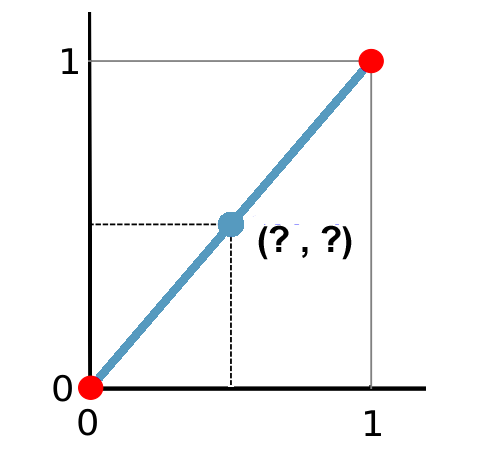

In [12]:
from IPython.display import Image, display
print("Linear Interpolation")
display(Image("https://gisgeography.com/wp-content/uploads/2016/05/Linear-Interpolation-2.png"))

### **Spatial Interpolation**
Spatial interpolation is a similar method, but applied to higher dimensional data.

Examples where it makes sense to apply spatial interpolation methods include:
- Estimating the rainfall in various neighborhoods when you have some rainfall data of the surrounding neighborhoods.
  - It makes sense to apply spatial interpolation here because the data is spatially correlated. That is, it’s more likely to rain 1 meter away compared to 500 meters away.

#### **Inverse Distance Weighting (IDW)**
There are many spatial interpolation algorithms to choose from, e.g., IDW, kriging, spline, etc.

IDW is a simple spatial interpolation algorithm that is often used. We will only consider IDW for this lab.

**How IDW Works:**

IDW allows you to estimate one point by conducting a weighted average of the neighboring points around it. The farther away a point is, the less it contributes to the estimate.

There are two main settings to IDW that you can change to improve your estimations.
  - **Number of Neighbors** The number of neighbors to consider in your estimation. The default tends to be about 5 neighbors.
  - **Power** The power governs how much neighboring points of different distances impact the value of the estimated point.
    - A lower power allows farther points to have a higher impact on the estimated point
    - A high power makes neighbors farther away impact the estimated point less
    - The default power tends to be 2

The image below illustrates a plane with four known values (in red) and a value we want to interpolate (in purple). In this illustration, the estimate of the unknown point will be some weighted average of 3 of its closest neighbors. We can vary the number of neighbors we consider in pursuit of better results.

Inverse Distance Weighting with 3 points


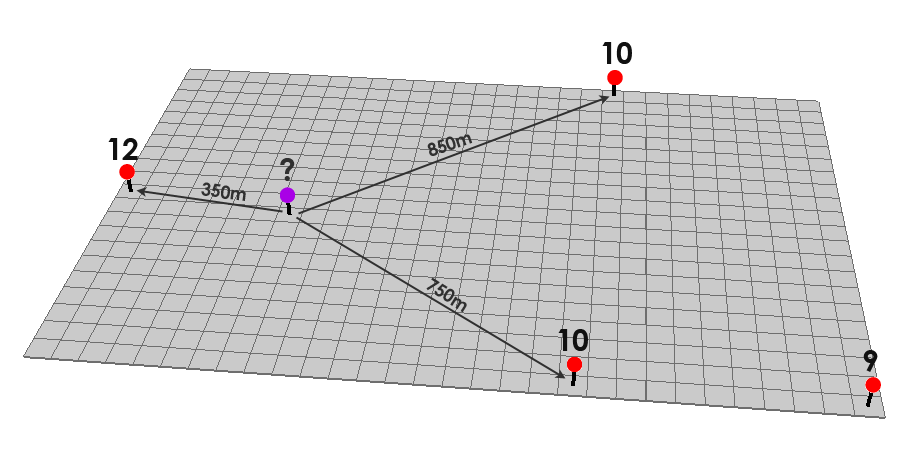

In [13]:
print("Inverse Distance Weighting with 3 points")
display(Image("https://gisgeography.com/wp-content/uploads/2016/05/IDW-3Points.png"))

**Power Setting: 1**

Immediately below, you'll find an illustration where an unknown point is found using a 3-neighbor IDW with a power of 1. The image following, illustrates the same data and settings, except the power is set to 2.

While it doesn't make a huge impact in this case, you can see that in the case of `power = 1`, the estimated value is lower because the points farther away are having more impact.

In the latter illustration, when `power = 2`, the estimated value is greater because the point closer to it is contributing more to the weighted average.

Illustration of spatial interpolation with a power of 1


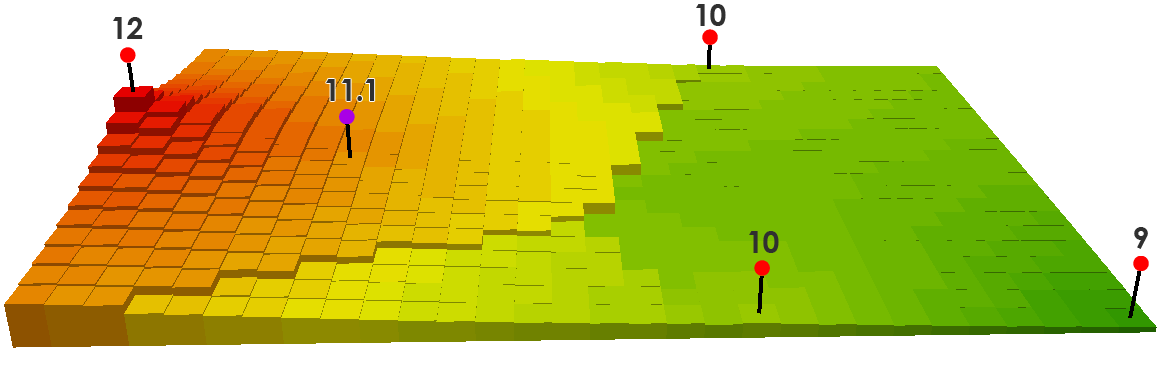

Illustration of spatial interpolation with a power of 2


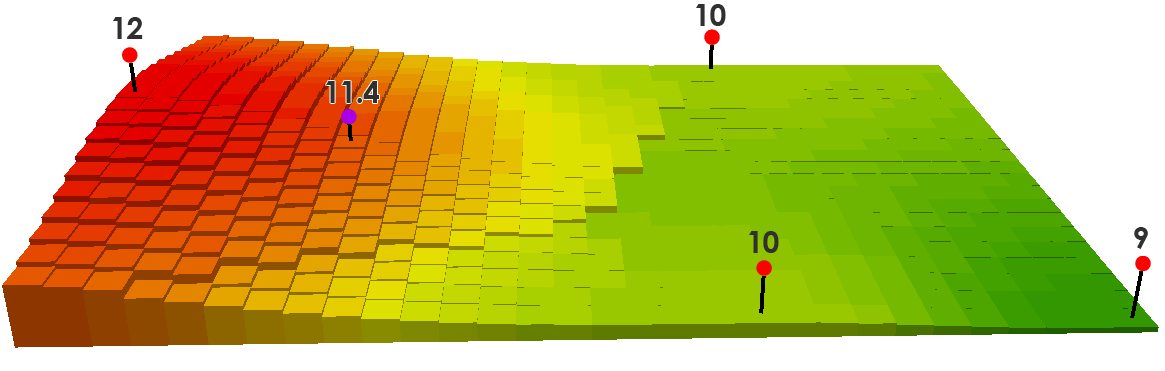

Inverse Distance Weighting formula


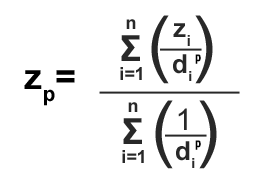

In [14]:
print("Illustration of spatial interpolation with a power of 1")
display(Image("https://gisgeography.com/wp-content/uploads/2016/05/IDW-Power1.png"))

print("Illustration of spatial interpolation with a power of 2")
display(Image("https://gisgeography.com/wp-content/uploads/2016/05/IDW-Power2.png"))

print("Inverse Distance Weighting formula")
display(Image("https://gisgeography.com/wp-content/uploads/2016/05/idw-formula.png"))

**Formula:**
You only need to understand this at a conceptual level, so feel free to ignore this formula. If you would like to develop a stronger mathematical intuition, here is the general formula for IDW.

# **3.b) Apply Interpolation to our Dataset**

Notice, we use a custom function `interpolate()` we provide it the censusData, our sampled data, the IDW power, and the number of neighbors.

In this example, our sample is `sample_1`, a random sample of 50% of the counties in Nebraska. Our `power` is set to the value of 2, and the number of neighbors, `numNeighbors`, is set to consider the nearest 5 neighbors.


In [15]:
# Instantiate the `IDWInterpolation` class:
idw_interpolation = IDWInterpolation()

# Interpolate the values
sample_1_interp = idw_interpolation.interpolate(censusData2020, sample_1, power=2, numNeighbors=5)

# Plot a sampled and interpolated data
idw_interpolation.plotSampleWithInterp(sample_1, sample_1_interp, county_plotter)


Output hidden; open in https://colab.research.google.com to view.

# **Performance Measure**

### **How do we measure the performance of our model?**
There is no straightforward answer to this. We can consider some common measures, but we may want to develop a measure more customized for our context. In general, our performance measure is going to be some function of the error between our poverty rate estimates and the actual value.

**Recall the General Goal:** To develop a map with estimated values that may eventually be used to inform how funds are distributed to people in poverty.

We want our performance measure to align with this aim. We can change elements of our method design, and check the performance using our performance measure. We can iteratively adapt the design and optimize to find what we think will be the 'best' design.

**Performance Measures We'll Consider:**
1. **Average Percent Error**
  - In general the error of an estimate is just: `actualValue - estimatedValue`
  - The average percent error is just an average of each of these errors
  - **Limitation** a key limitation of this method is that we can have a 0% error even when we have large errors. Consider the case of an error where we overestimate a value by 10% and underestimate a value by 10%. Our average error of these two estimates would average to be 0% error.
2. **Average Absolute Error**
  - Average absolute error takes the average of the absolute value of the percent error. This way, we can see the average magnitude of error.
  - **Limitation** a huge error counts just about as much as a small error
3. **Mean Squared Error**
  - The mean squared error squares each of the errors and then averages them.
  - Since the error is squared before it is averaged, large errors penalize the performance score by a lot more than small errors do.
  - **Limitation** the mean squared error is a relative measure and only really makes sense when you are comparing the mean squared error of two models.
4. **Root Mean Squared Error**
  - This method is the square root of the mean squared error
  - This is often used in machine learning
5. **Binary Classification of Error Below a Threshold**
  - This measure calculates the percentage of estimations whose absolute error is less than a certain value. (e.g., what percent of our estimations have less than a 3% error?)
6. **Errors 1-4 by Poverty Quartile** (Lowest poverty, "middle low" poverty, "middle-high" poverty, and Highest poverty)
  - We want to make sure we have high accuracy estimates particularly for households in high poverty, since resource distribution decisions may be made on this basis.
  - It may make sense for us to look at the error measures among subgroups. This measure, measure the above poverty errors, but does so for the poverty quartiles.


In [16]:
# Get the real values that correspond to the interpolated values
sample_1_interp_withActual = idw_interpolation.getRealvaluesGivenInterpolated(censusData2020, sample_1_interp)

# Calculate the error
error_calculator = ErrorCalculator()
percentBound = 3
errors = error_calculator.getErrors(sample_1_interp_withActual, percentBound, printErrors=True)


Average Error: 0.9200634313461862
Average Absolute Error: 3.9479899560221123
Mean Squared Error: 24.579337782437346
Root Mean Squared Error: 4.957755316918872
Percent Predicted With Smaller than a 3% error: 46.808%




In [21]:
result = error_calculator.getErrorsByQuartile(sample_1_interp_withActual, percentBound, printErrors=True)
quartile_errors = result['quartile_errors']
poverty_ranges = result['poverty_ranges']
quartile_errors

ERROR FOR QUARTILE #1 -- 3.2% poverty to 6.7% poverty:

ERROR FOR QUARTILE #2 -- 7.2% poverty to 10.7% poverty:

ERROR FOR QUARTILE #3 -- 10.9% poverty to 14.5% poverty:

ERROR FOR QUARTILE #4 -- 14.7% poverty to 22.2% poverty:


<ipython-input-1-7f5521f72acd>:488: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



{'Quartile 1 Errors': {'Average Error': 6.578005444396308,
  'Average Absolute Error': 6.578005444396308,
  'Mean Squared Error': 48.43649726087801,
  'Root Mean Squared Error': 6.959633414259548,
  'Percent Under Error Threshold': '0.0%'},
 'Quartile 2 Errors': {'Average Error': 2.1238431817910635,
  'Average Absolute Error': 2.36272123752361,
  'Mean Squared Error': 9.141449935144704,
  'Root Mean Squared Error': 3.0234830800162755,
  'Percent Under Error Threshold': '81.818%'},
 'Quartile 3 Errors': {'Average Error': -0.5596421489876071,
  'Average Absolute Error': 1.7929289332877973,
  'Mean Squared Error': 4.288322584697693,
  'Root Mean Squared Error': 2.0708265462606215,
  'Percent Under Error Threshold': '75.0%'},
 'Quartile 4 Errors': {'Average Error': -4.36163777261128,
  'Average Absolute Error': 4.926198482339193,
  'Mean Squared Error': 35.16459069508794,
  'Root Mean Squared Error': 5.929973920270471,
  'Percent Under Error Threshold': '33.333%'}}

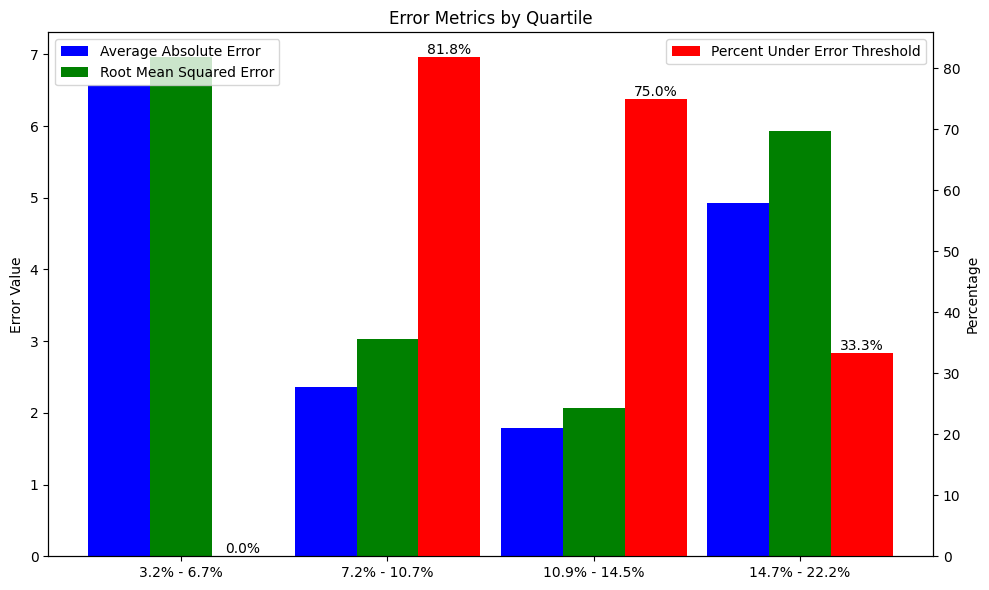

In [19]:
error_visualizer = ErrorVisualizer()  # Create an instance of ErrorVisualizer class
error_visualizer.plot_error_barchart(quartile_errors, poverty_ranges)

## <b>Example Interpretation of Default</b>

Based on the quartile errors you have obtained, we can interpret the performance of your interpolation method and sampling techniques on the poverty data. Here's an example interpretation of the errors and insights that can help you with the exercises:

### Quartile Errors and Performance

1. **Quartile 1 (3.2% to 7.6% poverty):** High errors, indicating lower accuracy for counties with lower poverty rates.
    - Average Absolute Error: 6.73%
    - Root Mean Squared Error: 7.14%
    - Predictions within 3% error threshold: 8.33%
    
2. **Quartile 2 (8.5% to 10.9% poverty):** Lower errors, suggesting better performance for counties with mid-range poverty rates.
    - Average Absolute Error: 2.24%
    - Root Mean Squared Error: 2.85%
    - Predictions within 3% error threshold: 81.82%

3. **Quartile 3 (11.0% to 13.4% poverty):** Low errors, indicating good performance for counties with mid-range poverty rates.
    - Average Absolute Error: 1.79%
    - Root Mean Squared Error: 2.3%
    - Predictions within 3% error threshold: 83.33%

4. **Quartile 4 (13.6% to 36.0% poverty):** High errors, suggesting lower accuracy for counties with higher poverty rates.
    - Average Absolute Error: 6.34%
    - Root Mean Squared Error: 8.89%
    - Predictions within 3% error threshold: 41.67%

### Methodology and Implications

- **Sampling Method:** Random selection (`getHalfCounties_random` function). May not be representative of the entire dataset, leading to uneven distribution and affecting interpolation accuracy.
- **Interpolation Method:** Inverse Distance Weighting (IDW) technique (`standard_idw` function). The choice of power and the number of nearest neighbors can influence accuracy.

The interpolation method performs well for mid-range poverty rates (Quartiles 2 and 3) but has higher errors for lower and higher poverty rates (Quartiles 1 and 4). Possible reasons:

1. Random sampling method might not provide a representative sample across poverty levels, leading to insufficient data for accurate interpolation.
2. The choice of power and the number of nearest neighbors in IDW method might not be optimal for all poverty levels, causing bias in estimates.

These design decisions have implications:

1. Inaccurate poverty estimates can impact resource allocation and support for people in need, causing disparities in assistance.
2. Random sampling method might not capture spatial patterns of poverty effectively, leading to less accurate interpolation.
3. The choice of power and the number of nearest neighbors in IDW method can influence trade-offs between accuracy, fairness, and transparency, with ethical implications.

# **Optimize and Reflect: Interpolation, Sampling, and Ethics**

In this section, you will work on improving the interpolation method settings and the sampling techniques. You will also discuss and analyze the ethical implications, development aspects, and stakeholder considerations of your approach.

**Exercise 1: Interpolation Methods and Sampling Techniques**
1. Modify the code below and try different interpolation method settings on different samples. Record your results for comparison.
2. Experiment with various sampling methods and analyze their performance using the performance measures discussed earlier.

**Exercise 2: Identifying Stakeholders and Evaluating Impacts**
1. Identify the direct and indirect stakeholders impacted by your methodological choices.
2. Analyze the potential consequences of your choices on these stakeholders, considering issues like accuracy, fairness, and transparency.

**Exercise 3: Ethical Considerations and Development Aspects**
1. Discuss the ethical implications of using different sampling methods and interpolation techniques when estimating poverty rates.
2. Reflect on the potential consequences of inaccurate estimates on the distribution of resources to people in poverty, and the implications for sustainable development goals.

**Exercise 4: Balancing Trade-offs and Navigating Dilemmas**
1. Evaluate the trade-offs between accuracy, fairness, and transparency in your methodological choices.
2. Explore potential solutions to ethical dilemmas you encounter in designing your methods, considering the needs and concerns of various stakeholders.

**Collaborative Activity: Group Discussion and Presentation**
1. Form small groups to discuss your findings from the exercises above. Share your insights and debate the pros and cons of different models, sampling methods, and performance measures in the context of ethical considerations and development impacts.
2. Each group will present their most promising model, sampling method, and performance measure, along with their reasoning and a discussion of ethical considerations, stakeholder implications, and development aspects.


In [38]:
# Interpolate the values
power = 2         # consider changing this value and observe interpret any changes in performance
numNeighbors = 5  # consider changing this value and observe interpret any changes in performance
sample = sample_2 # consider changing this value and observe interpret any changes in performance
sample_2_interp = idw_interpolation.interpolate(censusData2020, sample, power, numNeighbors)

# Plot a sampled and interpolated data
idw_interpolation.plotSampleWithInterp(sample_2, sample_2_interp, county_plotter)

# Get the real values that correspond to the interpolated values
sample_2_interp_withActual = idw_interpolation.getRealvaluesGivenInterpolated(censusData2020, sample_2_interp)

# Calculate the error
percentBound = 3
overallErrors = pd.DataFrame.from_dict({"Sample Results": error_calculator.getErrors(sample_2_interp_withActual, percentBound)})
errorsByQuartile = pd.DataFrame.from_dict(error_calculator.getErrorsByQuartile(sample_2_interp_withActual, percentBound))

Output hidden; open in https://colab.research.google.com to view.

In [27]:
overallErrors

,Sample Results
Average Absolute Error,4.43028
Average Error,1.561561
Mean Squared Error,29.053239
Percent Under Error Threshold,36.956%
Root Mean Squared Error,5.390106


In [28]:
errorsByQuartile

,Quartile 1 Errors,Quartile 2 Errors,Quartile 3 Errors,Quartile 4 Errors
Average Error,7.468757,2.739632,-0.502834,-3.139077
Average Absolute Error,7.468757,3.076405,2.377943,4.880194
Mean Squared Error,61.144233,14.758129,11.941773,29.617114
Root Mean Squared Error,7.819478,3.841631,3.455687,5.442161
Percent Under Error Threshold,0.0%,58.333%,72.727%,16.666%


**Assignment: Census Bureau Brief and Recommendations**
1. In your lab groups, review the existing data and findings from your spatial interpolation exercises for estimating poverty rates in Nebraska. Given the scope of this lab, we didn't extend it to the United States, but use your findings from Nebraska for this assignment.
2. Write a brief 'policy brief' (1-2 pages) that:
    
    a. Summarizes your findings from the exercises, focusing on the methods used, the ethical considerations, and the development implications.
    
    b. Discusses the challenges and limitations of using spatial interpolation methods for estimating poverty rates in Nebraska.
    
    c. Presents recommendations for using spatial interpolation methods, sampling techniques, and performance measures in Nebraska, along with justifications for their suitability.
   
    d. Reflects on the trade-offs, dilemmas, and potential consequences of implementing your recommendations in the context of Nebraska.
    
3. Include a one-page executive summary of your policy brief at the beginning, summarizing the key points and recommendations.

Submit your policy brief along with any code you modified or developed during the exercises.
